# Abstract
 - 「お弁当の需要予測」という小規模なデータセットのコンペを題材に、売上の要因を簡単に分析しながらモデルを組み立てるところまで実施した
 - 線形と非線形のモデル２つを作成し、これを組み合わせて予測を行う手法を今回は試みた
 - Trainデータでのクロスバリデーションの結果、RMSEは11前後程度となった


# Introduction
 - 「お弁当の需要予測」は実際にお昼に販売されたお弁当の売り上げ数を予測する問題で、回帰問題として分類されます。
 - データサイズはとても小さいですが、生のデータであり、データ加工等の工夫が検討できる良いデータセットです。
 - まずはデータを読み込み、売り上げ数と説明変数との関係を簡単な基礎分析で見ていきます

In [1]:
# データ分析ライブラリpandasをpdという名前でインポート
import pandas as pd
# 数値計算ライブラリnumpyをnpという名前でインポート
import numpy as np
# グラフ描画ライブラリmatplotlibのpyplotをpltという名前でインポート
from matplotlib import pyplot as plt
# グラフ描画ライブラリseabornをsnsという名前でインポート
import seaborn as sns
# seabornの日本語フォントとスタイルを設定
sns.set(font="IPAexGothic",style="white")

!pip install japanize-matplotlib
import japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 34.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=cd8433a86a4e55a75b2a24f0b591168dfe5d26d33d2bf82621965c2fd41dc33f
  Stored in directory: /root/.cache/pip/wheels/c1/f7/9b/418f19a7b9340fc16e071e89efc379aca68d40238b258df53d
Successfully built japanize-matplotlib


In [2]:
train = pd.read_csv("/content/drive/MyDrive/SIGNATE/tutorial/obento/train.csv")
test = pd.read_csv("/content/drive/MyDrive/SIGNATE/tutorial/obento/test.csv")
sample = pd.read_csv("/content/drive/MyDrive/SIGNATE/tutorial/obento/sample.csv",header=None)
print("Data Shapes")
print("Train:",train.shape, "Test:",test.shape, "Sample:",sample.shape)

Data Shapes
Train: (207, 12) Test: (40, 11) Sample: (40, 2)


In [3]:
# trainデータフレームのインデックスをdatetime列を元に日付型に変換
train.index = pd.to_datetime(train["datetime"])
# trainデータフレームの先頭5行を表示
train.head()

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
datetime,,,,,,,,,,,,
2013-11-18,2013-11-18,90,月,0,厚切りイカフライ,NaN,NaN,NaN,NaN,快晴,--,19.8
2013-11-19,2013-11-19,101,火,1,手作りヒレカツ,NaN,NaN,NaN,NaN,快晴,--,17.0
2013-11-20,2013-11-20,118,水,0,白身魚唐揚げ野菜あん,NaN,NaN,NaN,NaN,快晴,--,15.5
2013-11-21,2013-11-21,120,木,1,若鶏ピリ辛焼,NaN,NaN,NaN,NaN,快晴,--,15.2
2013-11-22,2013-11-22,130,金,1,ビッグメンチカツ,NaN,NaN,NaN,NaN,快晴,--,16.1


In [4]:
# trainデータフレームの数値データの要約統計量を表示
train.describe()

,y,soldout,kcal,payday,temperature
count,207.000000,207.000000,166.000000,10.0,207.000000
mean,86.623188,0.449275,404.409639,1.0,19.252174
std,32.882448,0.498626,29.884641,0.0,8.611365
min,29.000000,0.000000,315.000000,1.0,1.200000
25%,57.000000,0.000000,386.000000,1.0,11.550000
50%,78.000000,0.000000,408.500000,1.0,19.800000
75%,113.000000,1.000000,426.000000,1.0,26.100000
max,171.000000,1.000000,462.000000,1.0,34.600000


In [5]:
# trainデータフレームのオブジェクト型（主に文字列）データの要約統計量を表示
train.describe(include="O")

,datetime,week,name,remarks,event,weather,precipitation
count,207,207,207,21,14,207,207
unique,207,5,156,6,2,7,8
top,2013-11-18,水,タンドリーチキン,お楽しみメニュー,ママの会,快晴,--
freq,1,43,6,12,9,53,169


In [6]:
# "payday"列の欠損値を0で埋める
train["payday"] = train["payday"].fillna(0)
# "precipitation"列の"--"を-1に変換し、それ以外を浮動小数点数に変換する
train["precipitation"] = train["precipitation"].apply(lambda x : -1 if x == "--" else float(x))
# "event"列の欠損値を"なし"で埋める
train["event"] = train["event"].fillna("なし")
# "remarks"列の欠損値を"なし"で埋める
train["remarks"] = train["remarks"].fillna("なし")
# "datetime"列から月を抽出し、"month"列を作成する
train["month"] = train["datetime"].apply(lambda x : int(x.split("-")[1]))

 - お弁当の売り上げ分布の確認
 - 日数が経過するにつれて売り上げが落ちて行っている
 - 落ちて行っているのにも関わらず、スパイクしている為、売り上げ数に寄与している何かしらのファクターがある？

<Axes: xlabel='datetime'>

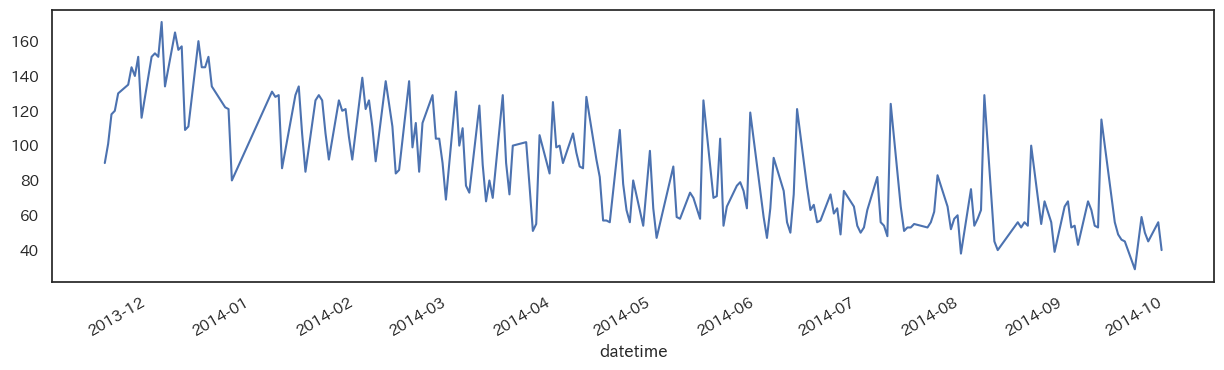

In [7]:
# 売り上げ(y)を時系列でプロットする
train["y"].plot(figsize=(15,4))

 - 目的変数と説明変数（数値変数）との散布図の確認
 - 月及び気温は売上数と相関が高そうだが、日数が経過するにつれて減衰している性質がある為、代替変数である可能性が高い

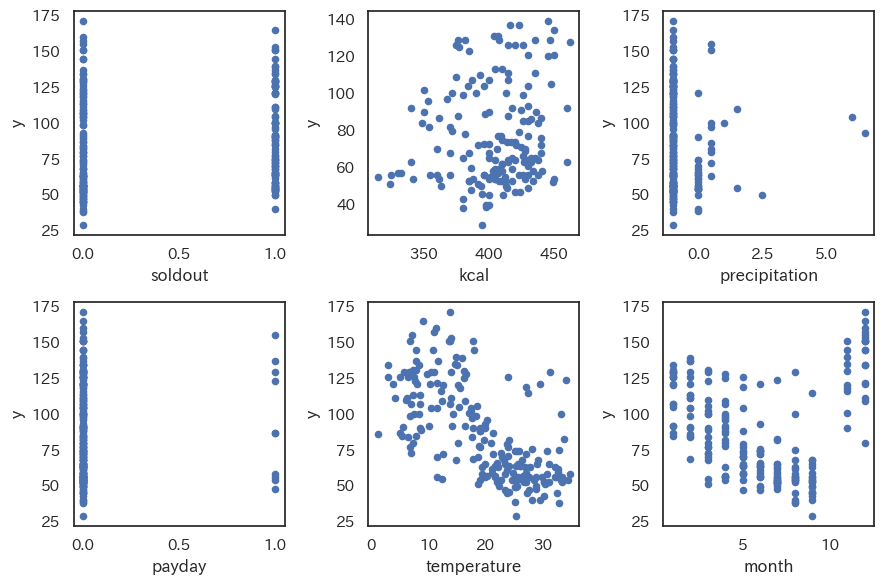

In [8]:
# 2行3列のグラフ領域を作成
fig, ax = plt.subplots(2,3,figsize=(9,6))
# 売り上げ(y)と完売(soldout)の散布図をプロット
train.plot.scatter(x="soldout", y="y", ax=ax[0][0])
# 売り上げ(y)とカロリー(kcal)の散布図をプロット
train.plot.scatter(x="kcal", y="y", ax=ax[0][1])
# 売り上げ(y)と降水量(precipitation)の散布図をプロット
train.plot.scatter(x="precipitation", y="y", ax=ax[0][2])
# 売り上げ(y)と給料日(payday)の散布図をプロット
train.plot.scatter(x="payday", y="y", ax=ax[1][0])
# 売り上げ(y)と気温(temperature)の散布図をプロット
train.plot.scatter(x="temperature", y="y", ax=ax[1][1])
# 売り上げ(y)と月(month)の散布図をプロット
train.plot.scatter(x="month", y="y", ax=ax[1][2])
# グラフのレイアウトを調整
plt.tight_layout()

 - 目的変数と説明変数（カテゴリー変数）との箱ひげ図の確認
 - 顕著に売上数に反応しているのはremarksの値がお楽しみメニューである時になしの場合と変化あり

 - お楽しみメニューを除いた場合に、後半の売り上げ数のスパイクが減少=スパイクの原因はお楽しみメニューであるかもしれない
 - お楽しみメニューがあるかないかで比較しても、中央値検定によれば有意に差がある

/tmp/ipython-input-3002811218.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(),rotation=90)


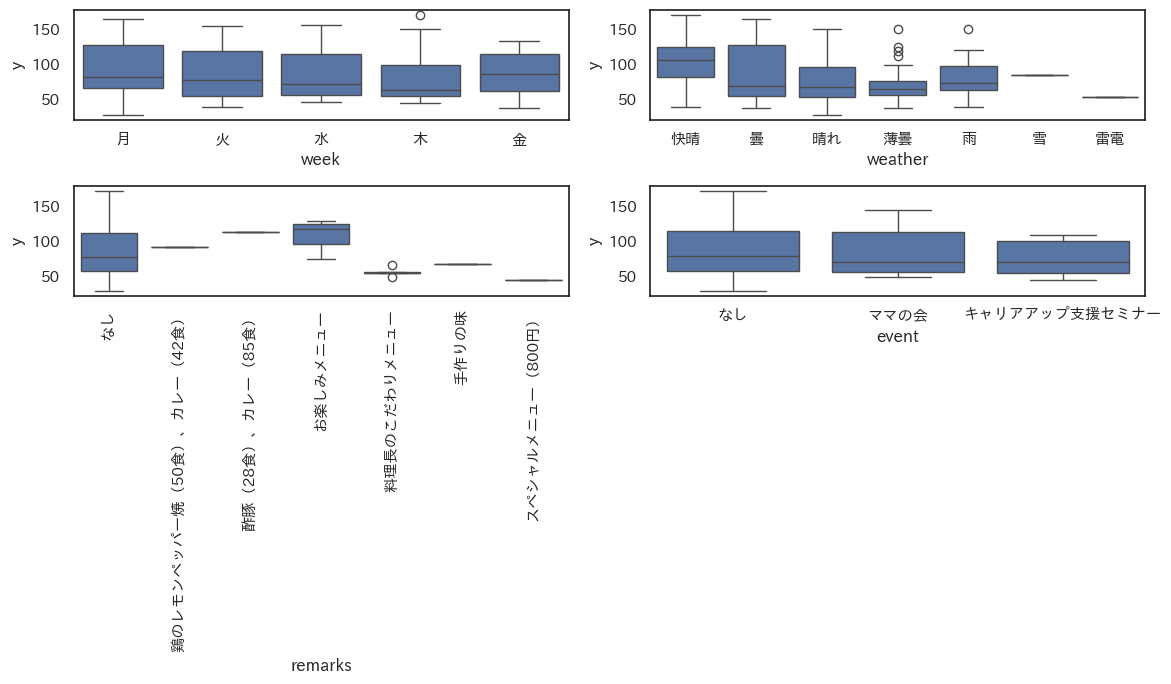

In [9]:
# 2行2列のグラフ領域を作成
fig, ax = plt.subplots(2,2,figsize=(12,7))
# 曜日(week)ごとの売り上げ(y)の箱ひげ図をプロット
sns.boxplot(x="week",y="y",data=train,ax=ax[0][0])
# 天気(weather)ごとの売り上げ(y)の箱ひげ図をプロット
sns.boxplot(x="weather",y="y",data=train,ax=ax[0][1])
# 特記事項(remarks)ごとの売り上げ(y)の箱ひげ図をプロット
sns.boxplot(x="remarks",y="y",data=train,ax=ax[1][0])
# x軸のラベルを30度回転
ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(),rotation=90)
# イベント(event)ごとの売り上げ(y)の箱ひげ図をプロット
sns.boxplot(x="event",y="y",data=train,ax=ax[1][1])
# グラフのレイアウトを調整
plt.tight_layout()

<Axes: xlabel='datetime'>

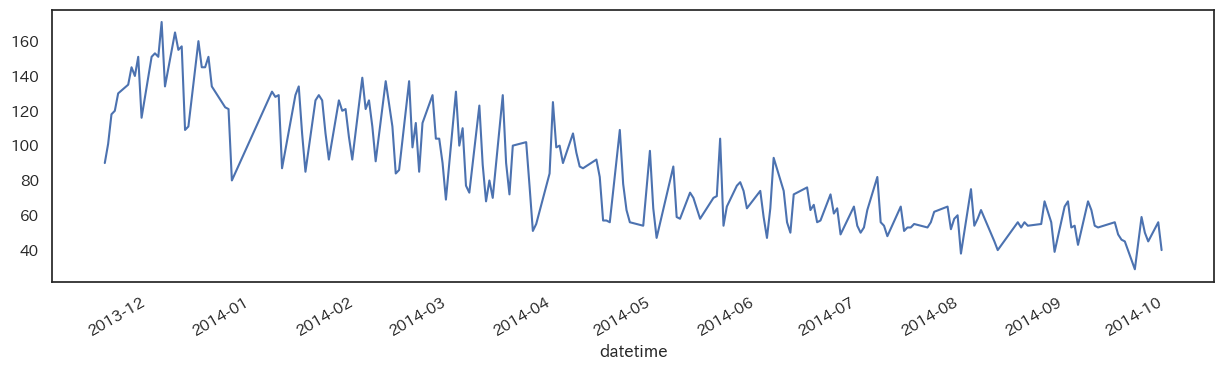

In [10]:
# "remarks"が"お楽しみメニュー"でないデータの売り上げ(y)を時系列でプロット
train[train["remarks"]!="お楽しみメニュー"]["y"].plot(figsize=(15,4))

<Axes: xlabel='fun', ylabel='y'>

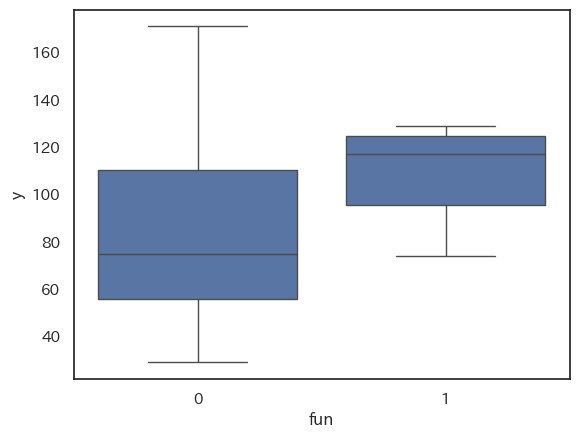

In [11]:
# "remarks"が"お楽しみメニュー"なら1、そうでなければ0となる"fun"列を作成
train["fun"] = train["remarks"].apply(lambda x: 1 if x=="お楽しみメニュー" else 0)
# "fun"ごとの売り上げ(y)の箱ひげ図をプロット
sns.boxplot(x="fun",y="y",data=train)

 - メディアン検定

In [12]:
# scipy.statsからmedian_testをインポート
from scipy.stats import median_test
# "fun"が1のグループと0のグループの売り上げ(y)で中央値検定を実施
stat,p,med,tbl = median_test(train[train["fun"]==1]["y"],train[train["fun"]==0]["y"])
# p値と統計量を表示
print("p",p,"stat",stat)

p 0.007057960766247775 stat 7.2581589841730345


 - お楽しみメニューの時の売り上げを見ると、この中でも凸凹がみられる

<Axes: xlabel='datetime'>

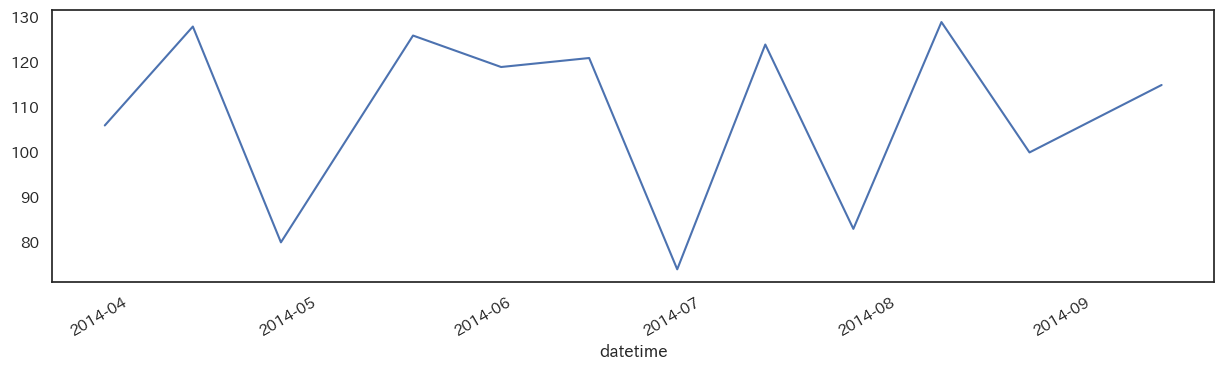

In [13]:
# "remarks"が"お楽しみメニュー"のデータの売り上げ(y)を時系列でプロット
train[train["remarks"]=="お楽しみメニュー"]["y"].plot(figsize=(15,4))

In [14]:
# "remarks"が"お楽しみメニュー"のデータを表示
train[train["remarks"]=="お楽しみメニュー"]

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature,month,fun
datetime,,,,,,,,,,,,,,
2014-03-28,2014-3-28,106,金,0,キーマカレー,NaN,お楽しみメニュー,なし,0.0,快晴,-1.0,18.5,3,1
2014-04-11,2014-4-11,128,金,1,チキンカレー,NaN,お楽しみメニュー,なし,0.0,快晴,-1.0,16.5,4,1
2014-04-25,2014-4-25,80,金,0,中華丼,NaN,お楽しみメニュー,なし,0.0,晴れ,-1.0,20.8,4,1
2014-05-16,2014-5-16,126,金,0,ポークカレー,NaN,お楽しみメニュー,ママの会,0.0,快晴,-1.0,23.8,5,1
2014-05-30,2014-5-30,119,金,0,チキンカレー,NaN,お楽しみメニュー,なし,0.0,薄曇,-1.0,26.9,5,1
2014-06-13,2014-6-13,121,金,0,キーマカレー,NaN,お楽しみメニュー,なし,0.0,晴れ,-1.0,29.5,6,1
2014-06-27,2014-6-27,74,金,0,牛丼,NaN,お楽しみメニュー,なし,0.0,雨,0.0,25.4,6,1
2014-07-11,2014-7-11,124,金,0,ポークカレー,NaN,お楽しみメニュー,なし,0.0,晴れ,-1.0,33.9,7,1
2014-07-25,2014-7-25,83,金,0,ひやしたぬきうどん・炊き込みご飯,NaN,お楽しみメニュー,なし,0.0,晴れ,-1.0,33.6,7,1


 - どうやらカレーか否かが重要そうである

<Axes: xlabel='curry', ylabel='y'>

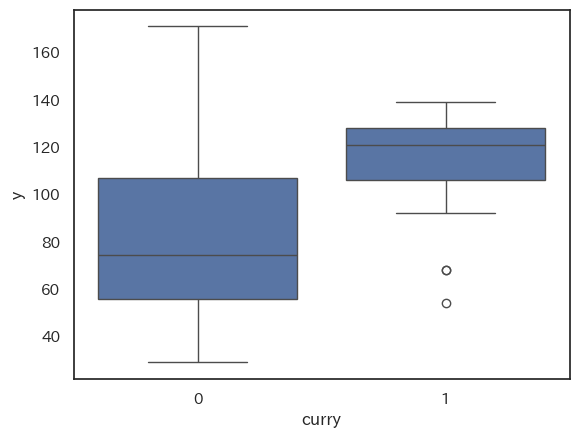

In [15]:
# "name"に"カレー"が含まれていれば1、そうでなければ0となる"curry"列を作成
train["curry"] = train["name"].apply(lambda x : 1 if x.find("カレー")>=0 else 0)
# "curry"ごとの売り上げ(y)の箱ひげ図をプロット
sns.boxplot(x="curry",y="y",data=train)

 - メディアン検定

In [16]:
# "curry"が1のグループと0のグループの売り上げ(y)で中央値検定を実施
stat,p,med,tbl = median_test(train[train["curry"]==1]["y"],train[train["curry"]==0]["y"])
# p値と統計量を表示
print("p:",p,"stat",stat)

p: 0.010699742900892427 stat 6.514516162828877


# Method
 - 方針としては日数が経過するにつれて減衰している為、売上数と日数の単回帰モデルを軸に検討する
 - 但し、2014-05以前はやや傾向が異なる為、学習データから除く
 - 他、お楽しみメニューやカレー等は大きく寄与はしていそうだが、非線形な関係であることも考慮し、Random Forestを用いて単回帰モデルの結果を修正するモデルも作成し、予測結果を導出することにする

In [17]:
# 訓練データを再度読み込む
train = pd.read_csv("/content/drive/MyDrive/SIGNATE/tutorial/obento/train.csv")
# テストデータを再度読み込む
test = pd.read_csv("/content/drive/MyDrive/SIGNATE/tutorial/obento/test.csv")
# 提出用のサンプルファイルを再度読み込む（ヘッダーなし）
sample = pd.read_csv("/content/drive/MyDrive/SIGNATE/tutorial/obento/sample.csv",header=None)

In [18]:
# trainデータに"t"列を追加し、値を1とする
train["t"] = 1
# testデータに"t"列を追加し、値を0とする
test["t"] = 0
# trainとtestを縦に結合し、インデックスをリセットする
dat = pd.concat([train,test],sort=True).reset_index(drop=True)

In [19]:
# datデータフレームのインデックスをdatetime列を元に日付型に変換
dat.index = pd.to_datetime(dat["datetime"])
# 2014年5月1日以降のデータのみを抽出
dat = dat["2014-05-01":]
# インデックスをリセット
dat = dat.reset_index(drop=True)

# インデックスを"days"列として追加
dat["days"] = dat.index
# "precipitation"列の"--"を-1に変換し、それ以外を浮動小数点数に変換する
dat["precipitation"] = dat["precipitation"].apply(lambda x : -1 if x=="--" else x).astype(float)
# "remarks"が"お楽しみメニュー"なら1、そうでなければ0となる"fun"列を作成
dat["fun"] = dat["remarks"].apply(lambda x: 1 if x=="お楽しみメニュー" else 0)
# "name"に"カレー"が含まれていれば1、そうでなければ0となる"curry"列を作成
dat["curry"] = dat["name"].apply(lambda x : 1 if x.find("カレー")>=0 else 0)

# モデルに使用する列を指定
cols = ["precipitation","weather","days","fun","curry","y"]

In [20]:
# === 特徴量エンジニアリング ===

# 1. 時系列特徴量
dat['is_monday'] = (dat['week'] == '月').astype(int)
dat['is_friday'] = (dat['week'] == '金').astype(int)

# 月末・月初効果
dat['day_of_month'] = pd.to_datetime(dat['datetime']).dt.day
dat['is_month_end'] = (dat['day_of_month'] >= 25).astype(int)
dat['is_month_start'] = (dat['day_of_month'] <= 5).astype(int)

# 2. 交互作用特徴量
# 天気×曜日
dat['weather_week'] = dat['weather'] + '_' + dat['week']

# お楽しみメニュー×天気（雨の日のお楽しみメニューは特に人気等）
dat['fun_weather'] = dat['fun'].astype(str) + '_' + dat['weather']

# 3. 数値特徴量の変換
# 気温の二乗項（非線形関係を捉える）
dat['temperature_squared'] = dat['temperature'] ** 2

# 降水量のカテゴリ化
dat['rain_category'] = 'no_rain'
dat.loc[dat['precipitation'] == -1, 'rain_category'] = 'missing'
dat.loc[dat['precipitation'] > 0, 'rain_category'] = 'light_rain'
dat.loc[dat['precipitation'] > 5, 'rain_category'] = 'heavy_rain'

# 4. メニュー関連特徴量
# メニュー名からの特徴抽出
dat['has_meat'] = dat['name'].str.contains('肉|チキン|豚|牛', na=False).astype(int)
dat['has_fish'] = dat['name'].str.contains('魚|サーモン|さば|鮭', na=False).astype(int)
dat['has_veggie'] = dat['name'].str.contains('野菜|サラダ', na=False).astype(int)

# カロリー帯（高カロリー = 1, 低カロリー = 0）
kcal_median = dat['kcal'].median()
dat['kcal_high'] = (dat['kcal'] > kcal_median).astype(int)

print("新しい特徴量を作成しました:")
print("形状:", dat.shape)
print("新特徴量の例:", ['is_monday', 'weather_week', 'temperature_squared', 'has_meat', 'rain_category'])

新しい特徴量を作成しました:
形状: (141, 29)
新特徴量の例: ['is_monday', 'weather_week', 'temperature_squared', 'has_meat', 'rain_category']


In [21]:
# 拡張された特徴量リスト
cols_extended = [
    # 基本特徴量
    "precipitation", "weather", "days", "fun", "curry", "temperature", "kcal", "payday",
    # 新特徴量
    "is_monday", "is_friday", "is_month_end", "is_month_start",
    "weather_week", "fun_weather", "temperature_squared",
    "rain_category", "has_meat", "has_fish", "has_veggie", "kcal_high",
    # 目的変数
    "y"
]

print("使用する特徴量数:", len(cols_extended)-1)  # yを除く
print("特徴量一覧:", [col for col in cols_extended if col != "y"])

使用する特徴量数: 20
特徴量一覧: ['precipitation', 'weather', 'days', 'fun', 'curry', 'temperature', 'kcal', 'payday', 'is_monday', 'is_friday', 'is_month_end', 'is_month_start', 'weather_week', 'fun_weather', 'temperature_squared', 'rain_category', 'has_meat', 'has_fish', 'has_veggie', 'kcal_high']


In [22]:
# KFold交差検証のためにKFoldをインポート
from sklearn.model_selection import KFold
# 評価指標として平均二乗誤差(MSE)をインポート
from sklearn.metrics import mean_squared_error as MSE
# 線形回帰モデルをインポート
from sklearn.linear_model import LinearRegression as LR
# ランダムフォレスト回帰モデルをインポート
from sklearn.ensemble import RandomForestRegressor as RF
import lightgbm as lgb

In [23]:
# 学習を行う関数を定義
def learning(trainX,y_train):
    # 線形回帰モデルのインスタンスを作成
    model1 = LR()
    # ランダムフォレスト回帰モデルのインスタンスを作成
    model2 = RF(n_estimators=100,max_depth=4,random_state=777)
    # model2 = lgb.LGBMRegressor(learning_rate=0.05,n_estimators=100,max_depth=4,random_state=777)
    # model1（線形回帰）を"days"列を特徴量として学習
    model1.fit(trainX["days"].values.reshape(-1,1),y_train)
    # model1で予測
    pred = model1.predict(trainX["days"].values.reshape(-1,1))

    # 目的変数とmodel1の予測値の差分を計算
    pred_sub = y_train - pred
    # model2（ランダムフォレスト）を"y"列を除いた特徴量で学習
    model2.fit(trainX.iloc[:, ~trainX.columns.str.match("y")],pred_sub)
    # 学習済みモデルを返す
    return model1, model2

 # Evaluation
 - cross validationでの検証からRMSEは大体11前後程度のモデルが作成できていることがわかる（大きく外れているのを除いた場合）
 - 売上数がスパイクする部分についてはそれなりに予測ができているように見える
 - 一方で、小さな凸凹についてはあまり予測ができておらず、説明変数の検討が更に必要
 - sklearnではRMSEは実装されていない為、MSEにルートをとり、導出する（累乗は**演算子を利用する）
 - ダミー変数化について
   - 天気情報の値がtrainにはあるがtestにはないものが存在する為、別々でダミー変数化をするとカラムの数が合わなくなる
   - その為、trainとtestを識別する為の適当な変数を作成してから一度結合し、ダミー変数化した後に戻すという手順を実施している

In [ ]:
# 5分割の交差検証を設定
kf = KFold(n_splits=5,random_state=777, shuffle=True)
# 訓練データのみを抽出（拡張された特徴量リストを使用）
tr = dat[dat["t"]==1][cols_extended]

# 訓練データと検証データのRMSEを格納するリスト
trains = []
tests = []
# 交差検証のループ
for train_index, test_index in kf.split(tr):
    # 訓練データに"tt"列=1を付与
    tr.loc[train_index,"tt"] = 1
    # 検証データに"tt"列=0を付与
    tr.loc[test_index,"tt"] = 0
    # "tt"列を整数型に変換
    tr["tt"] = tr["tt"].astype(int)
    # カテゴリ変数をダミー変数に変換
    tmp = pd.get_dummies(tr)

    # 訓練データ（特徴量）を抽出
    trainX = tmp[tmp["tt"]==1]
    del trainX["tt"]
    # 検証データ（特徴量）を抽出
    testX = tmp[tmp["tt"]==0]
    del testX["tt"]
    # 訓練データ（目的変数）を抽出
    y_train = tmp[tmp["tt"]==1]["y"]
    # 検証データ（目的変数）を抽出
    y_test = tmp[tmp["tt"]==0]["y"]

    # モデルを学習
    model1, model2 = learning(trainX, y_train)

    # 訓練データの予測
    pred_train = model1.predict(trainX["days"].values.reshape(-1,1)) + model2.predict(trainX.iloc[:, ~trainX.columns.str.match("y")])
    # 検証データの予測
    pred_test = model1.predict(testX["days"].values.reshape(-1,1)) + model2.predict(testX.iloc[:, ~testX.columns.str.match("y")])

    # 訓練データと検証データのRMSEを計算して表示
    print("TRAIN:",MSE(y_train,pred_train)**0.5, "VARIDATE",MSE(y_test, pred_test)**0.5)
    # RMSEをリストに追加
    trains.append(MSE(y_train,pred_train)**0.5)
    tests.append(MSE(y_test, pred_test)**0.5)
# RMSEの平均値を表示
print("AVG")
print(np.array(trains).mean(), np.array(tests).mean())

TRAIN: 7.878691946699353 VARIDATE 10.756255997126631
TRAIN: 7.934279650168929 VARIDATE 10.226259072591304
TRAIN: 8.223365349030384 VARIDATE 7.654816188613056
TRAIN: 7.262769357987639 VARIDATE 13.826314671505262
TRAIN: 8.167632911501304 VARIDATE 9.619186475024971
AVG
7.893347843077523 10.416566480972245


RMSE 7.986229908417227


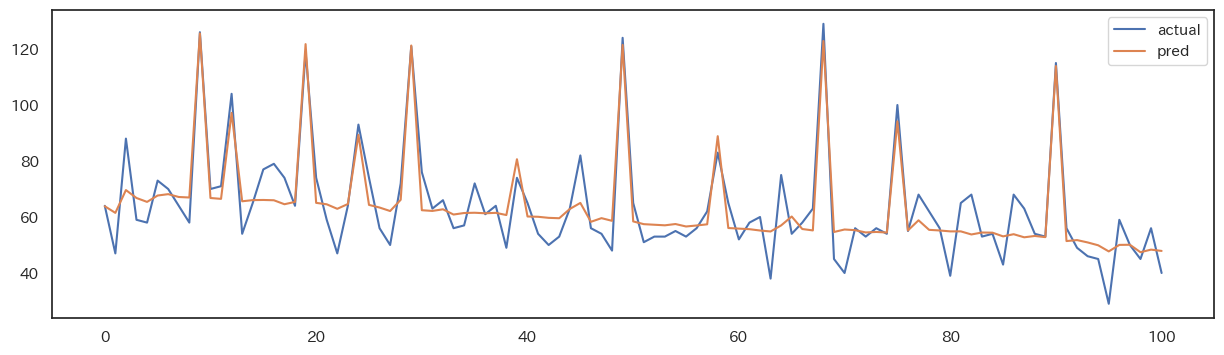

In [ ]:
# モデルに使用する列を指定（拡張された特徴量リストを使用）
cols_final = [col for col in cols_extended if col != "y"] + ["t", "y"]
# カテゴリ変数をダミー変数に変換
tmp = pd.get_dummies(dat[cols_final])
# 訓練データ（特徴量）を抽出
trainX = tmp[tmp["t"]==1]
del trainX["t"]
# テストデータ（特徴量）を抽出
testX = tmp[tmp["t"]==0]
del testX["t"]
# 訓練データ（目的変数）を抽出
y_train = tmp[tmp["t"]==1]["y"]
# テストデータ（目的変数）を抽出
y_test = tmp[tmp["t"]==0]["y"]
# モデルを学習
model1, model2 = learning(trainX,y_train)
# 訓練データの予測
pred = model1.predict(trainX["days"].values.reshape(-1,1)) + model2.predict(trainX.iloc[:,~trainX.columns.str.match("y")])

# 実測値と予測値をデータフレームに格納
p = pd.DataFrame({"actual":y_train,"pred":pred})
# 実測値と予測値をプロット
p.plot(figsize=(15,4))
# RMSEを計算して表示
print("RMSE",MSE(y_train,pred)**0.5)

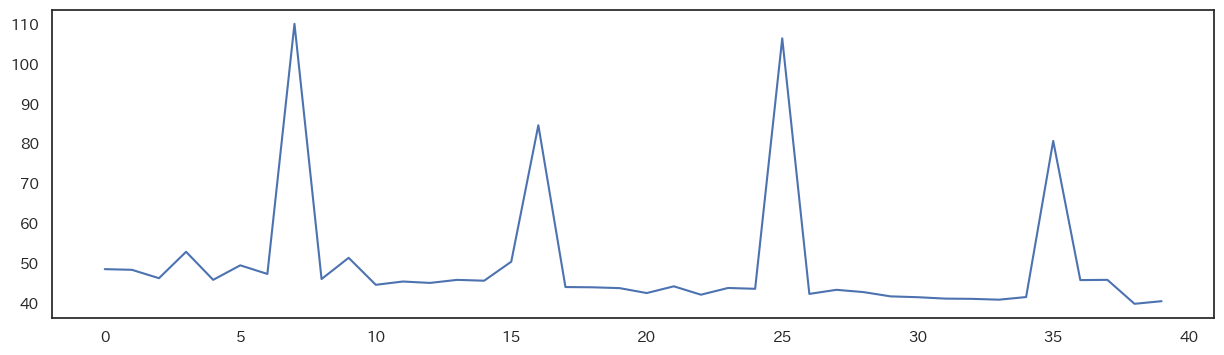

In [26]:
# モデルを学習
model1, model2 = learning(trainX,y_train)
# テストデータの予測
pred = model1.predict(testX["days"].values.reshape(-1,1)) + model2.predict(testX.iloc[:,~testX.columns.str.match("y")])
# グラフのサイズを指定
plt.figure(figsize=(15,4))
# 予測結果をプロット
plt.plot(pred)

In [27]:
# sampleデータフレームの1列目に予測結果を代入
sample[1] = pred
# 提出用ファイルとしてCSVに出力（インデックス、ヘッダーなし）
sample.to_csv("submit02.csv",index=None,header=None)

後で消す

In [28]:
# # fin.csvを読み込む
# fin = pd.read_csv("./fin.csv",header=None)
# # fin.csvのデータと予測値のRMSEを計算
# MSE(fin[1],pred)**0.5

In [29]:
# # fin.csvのデータと予測値をデータフレームに格納してプロット
# pd.DataFrame({"actual":fin[1],"pred":pred}).plot(figsize=(15,5))

# Conclution
 - お弁当の需要予測を題材とし、基礎分析の結果から2種類のモデルを利用した。
 - 1つ目は日数が経過することに減少傾向だったため、日数と需要量との単回帰モデルである。
 - 2つ目は上記予測結果を更に細かく補正する為の非線形なモデルとしてRandomForestを採用した。
   - スパイク要因に注目したところ、お楽しみメニューやカレーかどうかが重要であり、これらを表す特徴量を加えた結果、スパイクが予測できていた
 - 課題としては、小さな凸凹に対しては予測が不十分と考えられる為、これらに有効な特徴量を検討することである。